In [2]:
from JupyterImport import *
from src.DataStandardize.ExpSpecific.Sep20 import Fixes
root_logger.setLevel(logging.WARNING)
import copy
from src.Scripts.SquareWaveAnalysis import avg_transition_sw


## Other functions used in this script

In [3]:
from src.DataStandardize.ExpSpecific.Sep20 import get_lct_name, get_real_lct
from src.Plotting.Plotly.PlotlyUtil import additional_data_dict_converter


In [137]:
# dats = get_dats((7468, 7470+1), overwrite=True)  # EXTREMETLY slow sweeping (1.3mV/s LP*200) trying to match Mar19 data

# dats = get_dats((7472, 7488+1))  # Theta vs HQPC bias  --> See Oct16_DCbias

# dats = get_dats((7489, 7492+1))  # 4 Positions along transition into gamma broadened
# dats.extend(get_dats((7599, 7601+1)))  # 3x weakly coupled position (trying to get better averaged entropy signal)
# dats.extend(get_dats((7690, 7692+1)))  # 3x Even more gamma broadened
# dats.extend(get_dats((7716, 7718+1)))  # 3x weakly coupled again, slightly offset from previous

# dats = get_dats((7493, 7574+1))  # 2 Sets along S shape in fine steps (right side only)
# dats.extend(get_dats((7602, 7683+1)))  # 2 Sets along S shape in fine steps (left side slightly overlapping with right)

# dats = get_dats((7719, 7813+1))  # Stability testing... First 21 are initial stability, then in 3s after that with increasing step sizes (out and back) then 9 without moving.. and repeat

# dats.extend(get_dats((7822, 7921+1)))  # Stability testing with new divider in LCT which doesn't overload DAC.. Same as above tests otherwise.

# dats.extend(get_dats((7923, 7928+1)))  # Stability testing in same gate position (approx) as old Stability vs time. 
# dats.extend(get_dats((7929, 7951+1)))  # Reduced width of initial scans from 1000 (which was a mistake) to 400, and other scans from 600 to 400
# dats.extend(get_dats((7952, 7969+1)))  # Same as above but with double heating

# # Old stability vs Time measurements
# dats.extend(get_dats((4295, 4402+1)))  # Entropy vs time... Nothing changing. 100mK, -50mT, 25% heat, 200mV/s 1 cycle, ~6min scans, 1000mV wide
# dats.extend(get_dats((4406, 4569+1)))  # dats4404 crashed and is corrupted (dat 4403 is the part 1 of that), 4405 is a lone part 2 because 4404 couldn't save again.


# dats = get_dats((8009, 8072+1))  # High bias 8? scans along weakly coupled transition preparing for longer low bias scans. Accidentally done with LCSS = -224mV (and corresponding LCB)

# dats.extend(get_dats((8073, 8104+1)))  # Same as above but with correct LCSS (-216mV) and corresponding LCB



# dats = get_dats((8228, 8259+1))  # Along LCT with LCSS at -210mV (only from -400 to -365mV LCT)
# dats.extend(get_dats((8260, 8311+1)))  # Along LCT again from -420 to -355mV with LCSS = -213mV
# dats.extend(get_dats((8312, 8363+1)))  # Along 

# dats.extend(get_dats((8708, 8795+1)))  # LCT at 50mK

# dats.extend(get_dats((8796, 8883+1)))  # LCT at 100mK all the way from too pinched off to gamma broadened with LCSS = -230 LCB = -650
# dats.extend(get_dats((8884, 8962+1)))  # LCT at 100mK all the way from too pinched off to gamma broadened with LCSS = -220 LCB = -670

dats = get_dats((8116, 8147+1))  # 3mV steps in LCSS (and corresponding change in LCB) to see if there is some S shape feature in one of those gates affecting us
dats.extend(get_dats((8148, 8199+1)))  # Added some to the sides and more in the middle
dats.extend(get_dats((8200, 8227+1)))  # Added more to sides

dats.extend(get_dats((8364, 8399+1)))  # Back to LCSS/LCB but going further negative in LCSS this time (with LCT more negative -420 vs -400)
dats.extend(get_dats((8400, 8487+1)))  # Wider range and smaller steps
dats.extend(get_dats((8488, 8515+1)))  # More negative in LCSS
dats.extend(get_dats((8516, 8591+1)))  # Same with -440mV LCT)

dats.extend(get_dats((8600, 8707+1)))  # 50mK LCSS/LCB with LCT at -440mV


for dat in dats:
    Fixes.fix_magy(dat)
    
dat_dict = {dat.datnum: dat for dat in dats}

100% (32 of 32) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (52 of 52) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (28 of 28) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (36 of 36) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (88 of 88) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (28 of 28) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (76 of 76) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (108 of 108) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


## Set up default fitting parameters, and use this to fit all/weakly coupled data

In [98]:
from src.DataStandardize.ExpSpecific.Sep20 import get_real_lct, get_lct_name        

In [99]:
filt_name = 'LCT'
filt_threshold = -200  # Real mV for LCT (because I use above fns to get real value)
filt_val = lambda dat: get_real_lct(dat)
filt_func = lambda dat: filt_val(dat) > filt_threshold  # Returns True if dat pair is gamma broadened (or starting to be gamma broadened)

In [100]:
analysis_params = EA.EA_params(bin_data=False, num_per_row=500,
                               sub_const=True, sub_const_range=(-350, -250),
                               sub_line=False, sub_line_range=(-4000, -600),
                               int_entropy_range=(250, 350),
                               allowed_amp_range=(0.1,1.601), default_amp=0.908,
                               allowed_dT_range=(0.001, 30.002), default_dT=2.415,
                               CT_fit_range=(-500, 500), CT_fit_func='i_sense', CT_fit_param_edit_kwargs={},
                               fit_param_edit_kwargs=dict(),
                               E_fit_range=(-500, 500), 
                               calculate_uncertainty=True, 
                               batch_uncertainty=10,
                               center_data=True)

# analysis_params = EA.EA_params(bin_data=False, num_per_row=500,
#                                sub_const=True, sub_const_range=(-350, -250),
#                                sub_line=False, sub_line_range=(-4000, -600),
#                                int_entropy_range=(250, 350),
#                                allowed_amp_range=(0.1,.601), default_amp=0.889,
#                                allowed_dT_range=(0.001, 0.002), default_dT=2.562,
#                                CT_fit_range=(-400, 400), CT_fit_func='i_sense_digamma', CT_fit_param_edit_kwargs=dict(param_name=['theta'], value=[22.1], vary=[False]),
#                                fit_param_edit_kwargs=dict(),
#                                E_fit_range=(-400, 400), 
#                                calculate_uncertainty=True, 
#                                batch_uncertainty=5,
#                                center_data=True)

In [101]:
# EA.standard_square_process(dats[0], analysis_params)

In [130]:
recalculate = False
dd = {d.datnum: d for d in dats}
for dat in progressbar(dats):
    if (recalculate or not hasattr(dat.Other, 'EA_values')) and not filt_func(dat):
        try:
            EA.standard_square_process(dat, analysis_params)
        except ValueError:
            print(f'Removing dat{dat.datnum} from list because it failed to fit')
            del dd[dat.datnum]
dats = [dd[k] for k in sorted(dd)]

N/A% (0 of 391) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
D:\OneDrive\UBC LAB\GitHub\Python\PyDatAnalysis\src\Scripts\SquareEntropyAnalysis.py:536: RuntimeWarning:

Mean of empty slice

D:\OneDrive\UBC LAB\GitHub\Python\PyDatAnalysis\src\Scripts\SquareEntropyAnalysis.py:140: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Removing dat8709 from list because it failed to fit


 97% (382 of 391) |##################### | Elapsed Time: 0:00:00 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 97% (383 of 391) |##################### | Elapsed Time: 0:00:00 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 98% (384 of 391) |##################### | Elapsed Time: 0:00:00 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 98% (385 of 391) |##################### | Elapsed Time: 0:00:01 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 98% (386 of 391) |##################### | Elapsed Time: 0:00:01 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 98% (387 of 391) |##################### | Elapsed Time: 0:00:01 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 99% (388 of 391) |##################### | Elapsed Time: 0

## Fit Dats that are Gamma broadened using some fixed values determined from weakly coupled

Filter the dats to get only dats that are gamma broadened (or whatever the filter is)

Set up some new fixed parameters

In [6]:
gamma_analysis_params = copy.copy(analysis_params)
gamma_analysis_params.sub_const=True
# gamma_analysis_params.sub_const_range=(-350, -250) # Set per data based on gamma value (might require processing twice)
# gamma_analysis_params.int_entropy_range = (350, 450) # Set per data "" "" 

gamma_analysis_params.allowed_amp_range = (0,10.01)
# gamma_analysis_params.default_amp = 0.949
gamma_analysis_params.allowed_dT_range = (1,1.01)
# gamma_analysis_params.default_dT = 2.470

gamma_analysis_params.CT_fit_func = 'i_sense_digamma'
gamma_analysis_params.CT_fit_param_edit_kwargs = {'param_name': ['theta'], 'value': [21.1], 'vary': [False]}

In [7]:
recalculate = True 
for dat in progressbar(dats):
    if (recalculate or not hasattr(dat.Other, 'EA_values')) and filt_func([dat]):
        if (vs:= getattr(dat.Other, 'EA_values', None)) is not None and not np.isnan(vs.g):
#             w = 250+3*vs.g
            w = 500
        else:
            gamma_analysis_params.calculate_uncertainty = False  # Speed up prelim calcs
            EA.standard_square_process(dat, gamma_analysis_params)  # Run once just for the i_sense_digamma fit
            gamma_analysis_params.calculate_uncertainty = True
            g = dat.Other.EA_values.g  # This should now exist having run processing already
#             w = 250+3*g
            w = 500
        gamma_analysis_params.sub_const_range = (-100-w, -w)
        gamma_analysis_params.int_entropy_range = (w, w+100)
        
        EA.standard_square_process(dat, gamma_analysis_params)


N/A% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
D:\OneDrive\UBC LAB\GitHub\Python\PyDatAnalysis\src\Scripts\SquareEntropyAnalysis.py:140: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

 28% (2 of 7) |#######                   | Elapsed Time: 0:00:03 ETA:   0:00:08D:\OneDrive\UBC LAB\GitHub\Python\PyDatAnalysis\src\Scripts\SquareEntropyAnalysis.py:579: RuntimeWarning:

Mean of empty slice

D:\OneDrive\UBC LAB\GitHub\Python\PyDatAnalysis\src\Scripts\SquareEntropyAnalysis.py:601: RuntimeWarning:

Mean of empty slice

100% (7 of 7) |##########################| Elapsed Time: 0:00:15 Time:  0:00:15


## Specific to dats 7489 -> 7718

In [215]:
# For looking at the 5 positions along transition ONLY

ap = copy.copy(analysis_params)
ap.CT_fit_func = 'i_sense_digamma'
ap.CT_fit_param_edit_kwargs = {'param_name': ['theta'], 'value': [21.1], 'vary': [False]}
ap.CT_fit_range = (-600, 600)
ap.allowed_amp_range = (0, 0.01)
ap.allowed_dT_range = (0, 0.01)
ap.default_dT = 2.415

# Rebuiling list of dats
dats = get_dats((7489, 7492+1))  # 4 Positions along transition into gamma broadened
dats.extend(get_dats((7599, 7601+1)))  # 3x weakly coupled position (trying to get better averaged entropy signal)
dats.extend(get_dats((7690, 7692+1)))  # 3x Even more gamma broadened
dats.extend(get_dats((7716, 7718+1)))  # 3x weakly coupled again, slightly offset from previous

dd = {dat.datnum: dat for dat in dats}
dats = list()

## Weakly coupled 
ds = [dd[num] for num in [7489, 7599, 7600, 7601]]
merged_data = EA.EA_data()
merged_data.x = ds[0].SquareEntropy.Processed.outputs.x
merged_data.trans_data = np.nanmean([d.SquareEntropy.Processed.outputs.averaged for d in ds], axis=0)
merged_data.entropy_data = np.nanmean([d.SquareEntropy.Processed.outputs.entropy_signal for d in ds], axis=0)

dat = dd[7489]
ap.default_amp = 0.907
ap.int_entropy_range = (250, 350)
ap.sub_const_range = (-400, -250)
EA.standard_square_process(dat, ap, data=merged_data)  # Uses the passed in data which is really 4 datasets combined
dats.append(dat)    

ds = [dd[num] for num in range(7716, 7718+1)]
merged_data = EA.EA_data()
merged_data.x = ds[0].SquareEntropy.Processed.outputs.x
merged_data.trans_data = np.nanmean([d.SquareEntropy.Processed.outputs.averaged for d in ds], axis=0)
merged_data.entropy_data = np.nanmean([d.SquareEntropy.Processed.outputs.entropy_signal for d in ds], axis=0)

dat = dd[7716]
ap.default_amp = 0.907
ap.allowed_amp_range = (0, 10)
ap.allowed_dT_range = (0, 10)
ap.int_entropy_range = (250, 350)
ap.sub_const_range = (-400, -250)
EA.standard_square_process(dat, ap, data=merged_data)  # Uses the passed in data which is really 4 datasets combined
dats.append(dat)    



ap.default_amp = 0.907


# g ~ 40
d = dd[7490]
# ap.allowed_amp_range = (0, 10.01)
# ap.default_amp = 0.87
ap.int_entropy_range = (400, 600)
ap.sub_const_range = (-600, -400)
EA.standard_square_process(d, ap)
dats.append(d)


# g ~ 85
d = dd[7491]
# ap.allowed_amp_range = (0, 10.01)
# ap.default_amp = 0.865
ap.int_entropy_range = (400, 600)
ap.sub_const_range = (-600, -400)
EA.standard_square_process(d, ap)
dats.append(d)


# g ~ 160
d = dd[7492]
# ap.allowed_amp_range = (0, 10.01)
# ap.default_amp = 0.85
ap.int_entropy_range = (300, 400)
ap.sub_const_range = (-600, -550)
EA.standard_square_process(d, ap)
dats.append(d)


# g ~ ???
ds = [dd[num] for num in range(7690, 7692+1)]
merged_data = EA.EA_data()
merged_data.x = ds[0].SquareEntropy.Processed.outputs.x
merged_data.trans_data = np.nanmean([d.SquareEntropy.Processed.outputs.averaged for d in ds], axis=0)
merged_data.entropy_data = np.nanmean([d.SquareEntropy.Processed.outputs.entropy_signal for d in ds], axis=0)

dat = dd[7691]
# ap.default_amp = 0.907
ap.int_entropy_range = (500, 700)
ap.sub_const_range = (-700, -500)
EA.standard_square_process(dat, ap, data=merged_data)  # Uses the passed in data which is really 3 datasets combined
dats.append(dat)    


100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (3 of 3) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (3 of 3) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (3 of 3) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
<ipython-input-215-4f56c74f2b4f>:24: RuntimeWarning:

Mean of empty slice

<ipython-input-215-4f56c74f2b4f>:25: RuntimeWarning:

Mean of empty slice

<ipython-input-215-4f56c74f2b4f>:37: RuntimeWarning:

Mean of empty slice

<ipython-input-215-4f56c74f2b4f>:38: RuntimeWarning:

Mean of empty slice

<ipython-input-215-4f56c74f2b4f>:88: RuntimeWarning:

Mean of empty slice

<ipython-input-215-4f56c74f2b4f>:89: RuntimeWarning:

Mean of empty slice



In [218]:
datas = list()
ds = [dat for dat in dats if dat.datnum in list(range(7489, 7492+1))+[7691, 7716]]
for dat in ds:
    datas.append(dat.Other.EA_values.efit_info.eval_fit(x=dat.Other.Data['x']))
# datas = np.array(datas)
# datas.shape
CU.save_to_mat(datas, [f'Dat{dat.datnum}_entropy_fit' for dat in ds], 'Temp/fits_to_dats_7489_to_7492_and_7691_7716.mat')

# Plot Averages

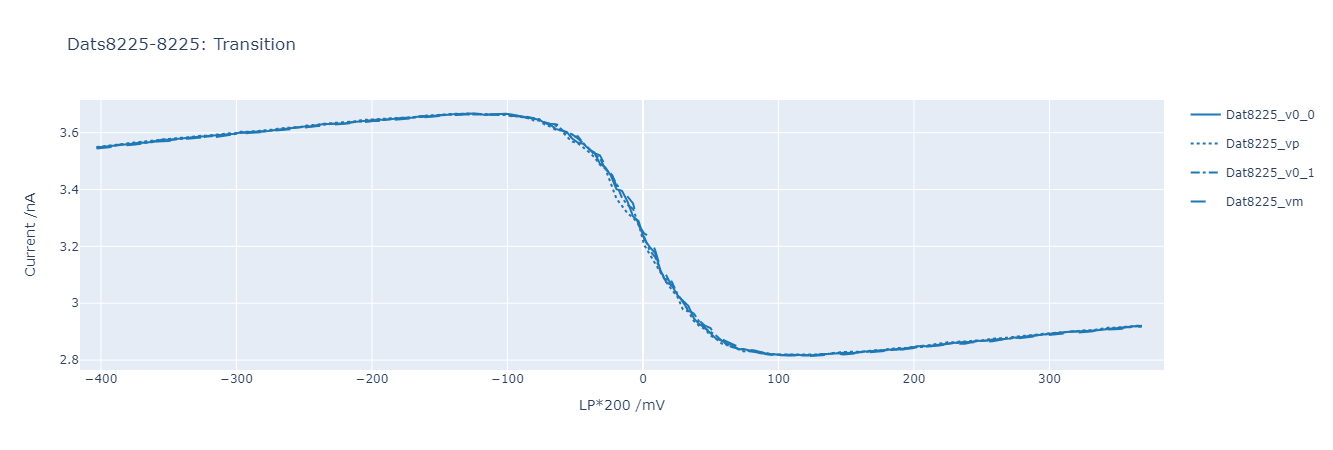

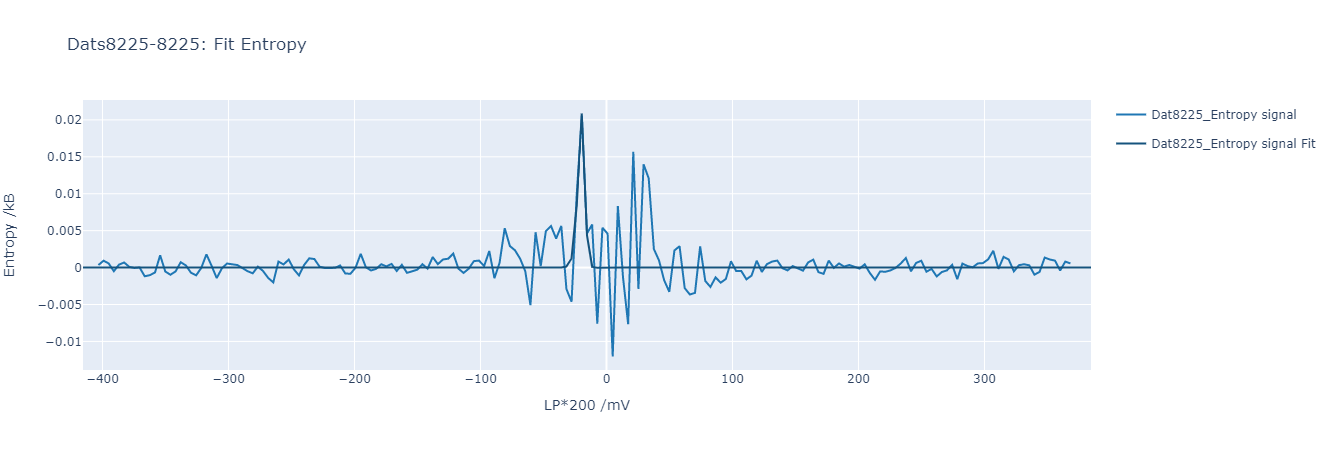

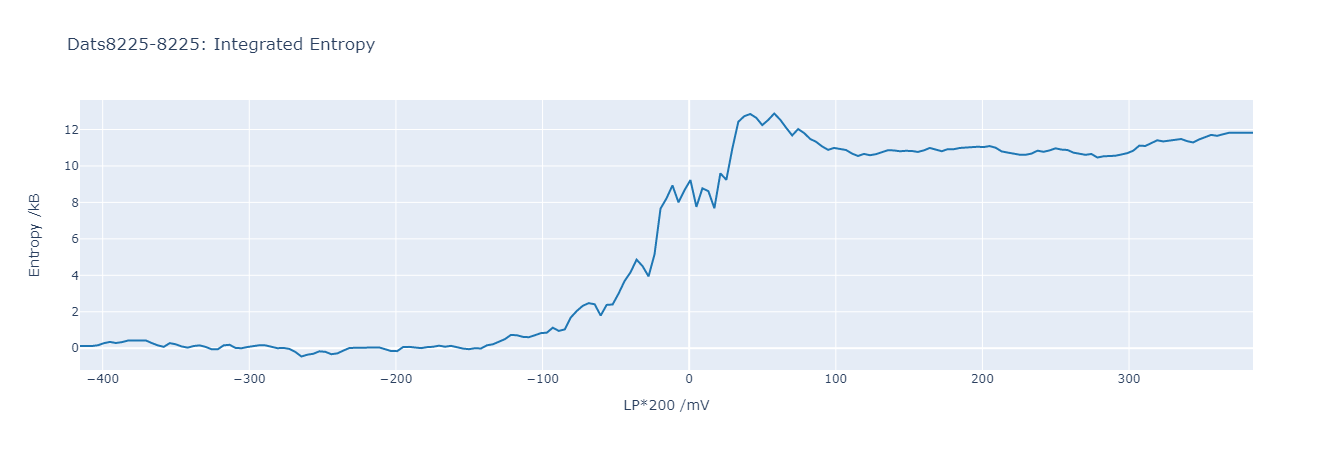

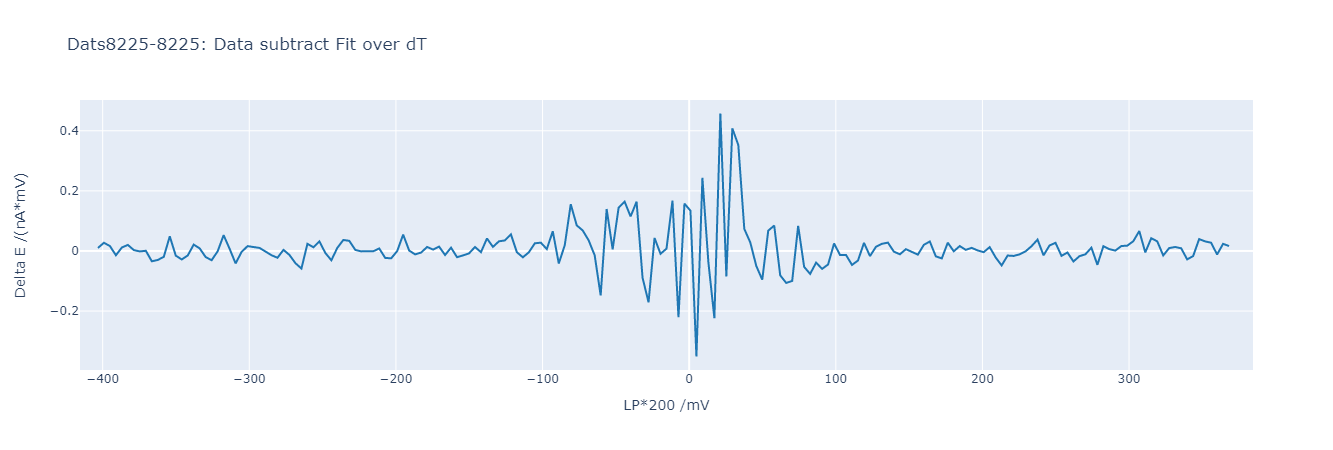

In [39]:
lims = (None, None)
dd = {dat.datnum: dat for dat in dats}
# start = 4893  #4881
start = 6146
single_dat = False
# ds = [dd[num] for num in [start, start+44, start+44*2]]  # 
a = 0
# ds = [dd[num] for num in [6219+a, 6275+a, 6331+a, 6517+a, 6182+a]]
# ds = [dd[num] for num in [7142, 7138, 7167, 7098, 7106, 7144, 7136, 7155, 7222, 7185]]
# ds = [dd[num] for num in [7163, 7128, 7124, 7185]]
# ds = [dd[num] for num in [7338, 7338+23, 7338+23*2]]
# ds = [dd[num] for num in [7078, 7157, 7173, 7185]]  # 4 points that I'm getting better data for Josh talk for
# ds = [dd[num] for num in [8236, 8286, 8337]]
# ds = [dd[num] for num in np.arange(start, start+10, 2)]
# ds = [dd[num] for num in list(range(8073, 8073+6*4+1, 4))]
ds = [dd[num] for num in [8225]]
# ds = dats
# ds = [dat for dat in dats if 0.85 < dat.Other.EA_values.int_dS < 0.95]
# ds = [dd[num] for num in np.arange(start, start+37, 4)]  # RCB
# ds = [dd[num] for num in np.arange(start, start+281, 40)]  # field
# ds = [dd[num] for num in np.arange(start, start+41, 8)]  # hqpc

additional_data = [
    dict(name='LCSS', func=lambda dat: dat.Logs.fds['LCSS'], precision='.1f'),
    dict(name='LCB',  func=lambda dat: dat.Logs.fds['LCB'], precision='.1f'),
    dict(name='LCT',  func=lambda dat: get_real_lct(dat), precision='.1f'),
    dict(name='LP*2',  func=lambda dat: dat.Logs.fds['LP*2'], precision='.1f'),
    dict(name='Bias',  func=lambda dat: dat.AWG.AWs[0][0][1], precision='.0f', units='mV'),
    dict(name='dT',  func=lambda dat: dat.Other.EA_values.dT, precision='.2f', units='mV'),
    dict(name='dS',  func=lambda dat: dat.Other.EA_values.dS, precision='.1f', units='kB'),
    dict(name='int_dS',  func=lambda dat: dat.Other.EA_values.int_dS, precision='.1f', units='kB'),
]

get_additional_data, additional_hover_template = additional_data_dict_converter(additional_data, customdata_start=1)
additional_hover_template = '<br>'.join(('<extra>%{fullData.name}', additional_hover_template, '</extra>'))


figt = EA.Plots.waterfall(ds[lims[0]:lims[1]], which='transition', mode='lines', add_fits=False, shift_per=0.0, get_additional_data=get_additional_data, additional_hover_template=additional_hover_template, single_dat=single_dat)
fige = EA.Plots.waterfall(ds[lims[0]:lims[1]], which='entropy', mode='lines', add_fits=True, shift_per=0.00, get_additional_data=get_additional_data, additional_hover_template=additional_hover_template, single_dat=single_dat)
figi = EA.Plots.waterfall(ds[lims[0]:lims[1]], which='integrated', mode='lines', add_fits=False, shift_per=0.0, get_additional_data=get_additional_data, additional_hover_template=additional_hover_template, single_dat=single_dat)
figdmf = EA.Plots.waterfall(ds[lims[0]:lims[1]], which='data_minus_fit_scaled', mode='lines', add_fits=False, shift_per=0.00, get_additional_data=get_additional_data, additional_hover_template=additional_hover_template, single_dat=single_dat)
figs = (figt, fige, figi, figdmf)
# figs = [figi]
for fig in figs:
    title = fig.layout.title.text
    field = ds[0].Logs.magy.field
    bias = ds[0].AWG.AWs[0][0][1]/10
#     fig.update_layout(title=title+f'<br>Field={field:.0f}mT, HQPC Bias={bias:.1f}nA')

for fig in figs:
    fig.show()

In [20]:
names = ('Transition', 'Entropy', 'Integrated Entropy', 'Data minus fit over dT')
save_graph=True
graphs_to_save = [2]
if save_graph:
    for i in graphs_to_save:
        figs[i].write_html(export_path+f'Dats{dats[0].datnum}-{dats[-1].datnum} -- Waterfall plot of {names[i]}.html')

# Plot Fit params per Dat

In [1]:
which_sorts = ['any_lct']*5
# which_sorts = ['lcb']*5
tols = [1]*5
which_ys = ['amp', 'dt', 'fit_ds', 'int_ds', 'g']
# which_xs = ['any_lct']*5
# which_xs = ['lp*2']*5
which_xs = ['lcb']*5
# which_xs = ['time_single_day']*5

# which_sorts = ['field']*4
# tols = [10]*4
# which_ys = ['amp', 'dt', 'fit_ds', 'int_ds']
# which_xs = ['field']*4

# dat_sets = [[d for d in dats if d.datnum <= 7533], [d for d in dats if  7533 < d.datnum <=7574], [d for d in dats if 7602 <= d.datnum < 7602+41], [d for d in dats if 7602+41 <= d.datnum < 7602+82]]   # Split into separate parts, might not be in order
# dat_sets = [CU.order_list(ds, [d.datnum for d in ds]) for ds in dat_sets]  # Put sets into datnum order

# dat_sets = [[d for d in dats if d.datnum <= 4569], [d for d in dats if  7719 <= d.datnum <=7813], [d for d in dats if 7822 <= d.datnum <= 7921], [d for d in dats if 7923 <= d.datnum <= 7951], [d for d in dats if 7952 <= d.datnum]]   # Split into separate parts, might not be in order
# dat_sets = [CU.order_list(ds, [d.datnum for d in ds]) for ds in dat_sets]  # Put sets into datnum order

# dat_sets = [[d for d in dats if d.datnum <= 8072], [d for d in dats if  8072 < d.datnum]]
# dat_sets = [CU.order_list(ds, [d.datnum for d in ds]) for ds in dat_sets]  # Put sets into datnum order

# dat_sets = [[d for d in dats if d.datnum <= 8227], [d for d in dats if  8227 < d.datnum <=8515], [d for d in dats if 8515 < d.datnum < 8600], [d for d in dats if 8600 <= d.datnum]]
# dat_sets = [CU.order_list(ds, [d.datnum for d in ds]) for ds in dat_sets]  # Put sets into datnum order

# dat_sets = [[d for d in dats if   d.datnum < 8796], [d for d in dats if  8796 <= d.datnum]]
# dat_sets = [CU.order_list(ds, [d.datnum for d in ds]) for ds in dat_sets]  # Put sets into datnum order

dat_sets = [[dat for dat in dats if 8516 <= dat.datnum < 8600], [dat for dat in dats if 8600 <= dat.datnum]]
dat_sets = [CU.order_list(ds, [d.datnum for d in ds]) for ds in dat_sets]  # Put sets into datnum order

# dat_sets = [[dat for dat in dats if 8708 <= dat.datnum <= 8795], [dat for dat in dats if 8795 < dat.datnum <= 8883]]
# dat_sets = [CU.order_list(ds, [d.datnum for d in ds]) for ds in dat_sets]  # Put sets into datnum order

# dat_sets = [[dat for dat in dats if dat.datnum < 8708] + [dat for dat in dats if 8795 < dat.datnum]]

# dat_sets = [[dat for dat in dats if dat.datnum < 8600]]

# dat_sets = [dats]

additional_data = [
    dict(name='LCSS', func=lambda dat: dat.Logs.fds['LCSS'], precision='.1f'),
    dict(name='LCB',  func=lambda dat: dat.Logs.fds['LCB'], precision='.1f'),
    dict(name='LCT',  func=lambda dat: get_real_lct(dat), precision='.1f'),
    dict(name='LP*2',  func=lambda dat: dat.Logs.fds['LP*2'], precision='.1f'),
    dict(name='Bias',  func=lambda dat: dat.AWG.AWs[0][0][1], precision='.0f', units='mV'),
    dict(name='dT',  func=lambda dat: dat.Other.EA_values.dT, precision='.2f', units='mV'),
    dict(name='dS',  func=lambda dat: dat.Other.EA_values.dS, precision='.2f', units='kB'),
    dict(name='int_dS',  func=lambda dat: dat.Other.EA_values.int_dS, precision='.2f', units='kB'),
    dict(name='Gamma',  func=lambda dat: dat.Other.EA_values.g, precision='.1f', units='mV'),
]

get_additional_data, additional_hover_template = additional_data_dict_converter(additional_data, customdata_start=1)
additional_hover_template = '<br>'.join(('<extra>%{fullData.name}', additional_hover_template, '</extra>'))

figs = list()

use_sets = True

if use_sets == True:
    for which_sort, which_y, which_x, tol in zip(which_sorts, which_ys, which_xs, tols):
        figs.append(EA.Plots.sorted(dat_sets[0], which_sort=which_sort, which_x=which_x, which_y=which_y, sort_tol=tol, uncertainties=None, get_additional_data=get_additional_data, additional_hover_template=additional_hover_template, legend_label=f'Dats{dat_sets[0][0].datnum}-{dat_sets[0][-1].datnum}'))
        if len(dat_sets) > 1:
            for ds in dat_sets[1:]:
                EA.Plots.sorted(ds, fig=figs[-1], which_sort=which_sort, which_x=which_x, which_y=which_y, sort_tol=tol, uncertainties=None, get_additional_data=get_additional_data, additional_hover_template=additional_hover_template, legend_label=f'Dats{ds[0].datnum}-{ds[-1].datnum}')
else:
    for which_sort, which_y, which_x, tol in zip(which_sorts, which_ys, which_xs, tols):
        figs.append(EA.Plots.sorted(dat_sets[0], mode='markers', which_sort=which_sort, which_x=which_x, which_y=which_y, sort_tol=tol, uncertainties=None, get_additional_data=get_additional_data, additional_hover_template=additional_hover_template))

            
            
for fig, ws in zip(figs, which_sorts):
    if len(dat_sets) > 1:
        fig.update_layout(legend_title='Arbitrary')
    else:
        fig.update_layout(legend_title = ws.upper())
    
#     fig.update_layout(title = fig.layout.title.text+f'<br>Temp = {dats[0].Logs.temps.mc*1000:.0f}mK, LCSS = {dats[0].Logs.fds["LCSS"]:.1f}mV, Heating Freq = {dats[0].AWG.freq:.1f}Hz')
for fig in figs:
    fig.show()
    pass

NameError: name 'dats' is not defined

In [8]:
save_graph=True
graphs_to_save = [0,1,2,3]
if save_graph:
    for i in graphs_to_save:
        figs[i].write_html(export_path+slugify(f'Dats{dats[0].datnum}-{dats[-1].datnum} -- Repeats along transition various {which_sorts[i]} -- {which_ys[i]} vs {which_xs[i]}', separator='-', regex_pattern=r'[^-a-zA-Z0-9_\ ]+', replacements=[['/', 'OVER'], ['.', 'DOT']], lowercase=False)+'.html')

In [132]:
fig = go.FigureWidget(figs[2])
fig

FigureWidget({
    'data': [{'customdata': array([[ 8.88400000e+03, -2.19730000e+02, -6.69860000e+02, ...,
   …

In [133]:
for data in fig.data:
    d = {x_val: np.mean([y for x, y in zip(data.x, data.y) if x == x_val]) for x_val in set(data.x)}
    d = {k: d[k] for k in sorted(d)}
    data.x = list(d.keys())
    data.y = list(d.values())

In [134]:
for data in fig.data:
    data.update(mode='markers+lines')

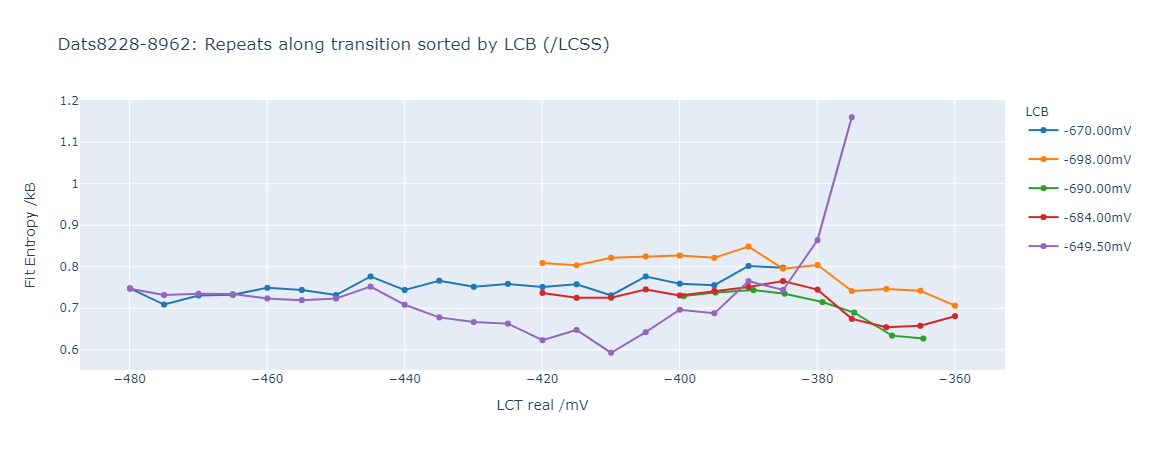

In [135]:
fig.show()

In [136]:
i = 2
fig.write_html(export_path+slugify(f'Dats{dats[0].datnum}-{dats[-1].datnum} -- Repeats along transition various {which_sorts[i]} -- {which_ys[i]} vs {which_xs[i]}', separator='-', regex_pattern=r'[^-a-zA-Z0-9_\ ]+', replacements=[['/', 'OVER'], ['.', 'DOT']], lowercase=False)+'.html')

In [ ]:
from scipy.stats import sem
f = figs[2]
xs, ys = list(), list()
for d in f.data:
    y = d.y
    y[np.where(y<0)] = np.nan
    x = np.nanmean(d.x)
    xs.append(x)
    ys.append((np.nanmean(y), sem(y)))

ys = CU.order_list(ys, xs)
xs = sorted(xs)
for x, y in zip(xs, ys):
    print(f'At LCT = {x:.1f}mV, Mean fit dS = {y[0]:.3f} {PM} {y[1]:.3f} kB')

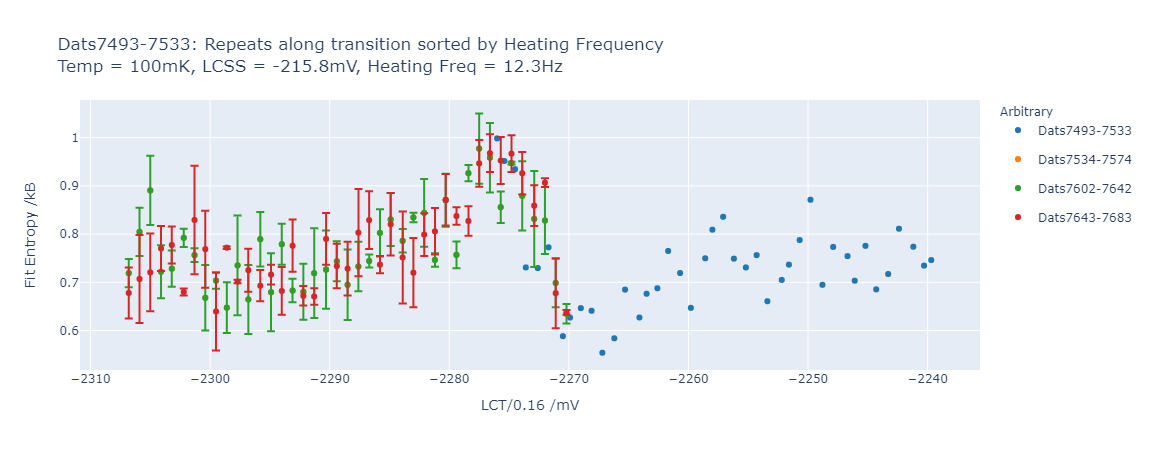

In [237]:
fig = figs[2]
fig2 = copy.copy(fig)

xs, datas = list(), list()
for data in fig.data:
    xs.append(data.x)
    datas.append(data.y)
xs = np.array(xs)
datas = np.array(datas)

xs = np.array([np.mean(xs[0:1], axis=0), np.mean(xs[2:3], axis=0)])
datas = np.array([np.mean(datas[0:1], axis=0), np.mean(datas[2:3], axis=0)])

bin_size=3
                  
for x, data, fd in zip(xs, datas, fig2.data):
    fd.x = x
    fd.y = data
    fd.error_y = dict()
fig2

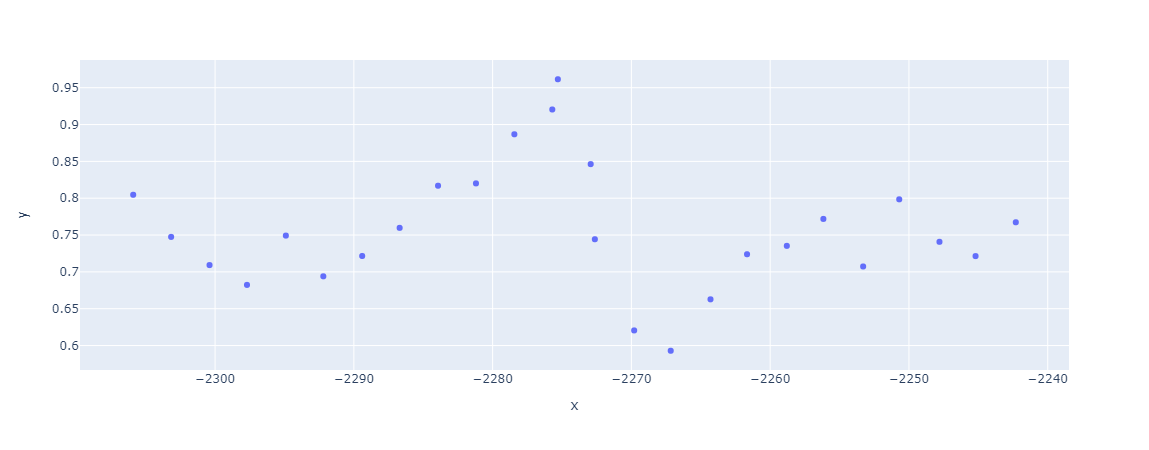

In [238]:
xs = CU.bin_data(xs, bin_size=bin_size)
datas = CU.bin_data(datas, bin_size=bin_size)

xs = np.array(list(xs[0])+list(xs[1]))
datas = np.array(list(datas[0])+list(datas[1]))

px.scatter(x=xs, y=datas)

In [227]:
datas

array([1.9330121, 1.6770227, 1.5295562, 1.4454374, 1.5660118, 1.5520096,
       1.6197584, 1.656806 , 1.6181514, 1.7516594, 1.7971184, 1.7932541,
       1.7234905], dtype=float32)

In [239]:

CU.save_to_mat([xs, datas], ['LCT', 'fit_entropy'], 'Temp/Binned fit entropy over S shape.mat')

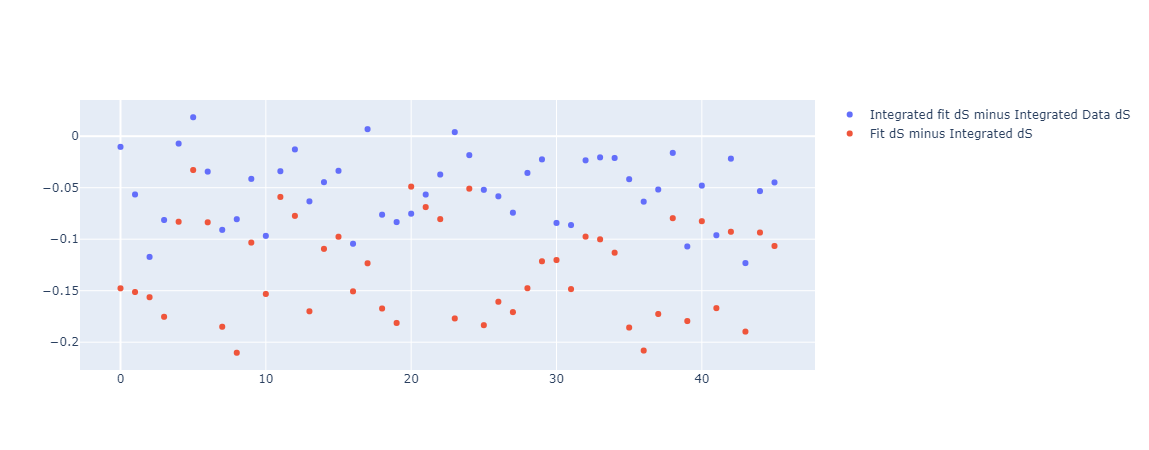

In [247]:
dat = dats[0]

fig = go.Figure()
diffs = list()
fminusint=list()
for dat in dats:
    
    data = EA.get_data(dat)
    values = dat.Other.EA_values

    int_fit = np.nancumsum(values.efit_info.eval_fit(data.x))*values.sf
    diffs.append(int_fit[-1] - data.integrated_data[-1])
    fminusint.append(values.dS - values.int_dS)

#     fig_i = go.Figure()
#     fig_i.add_trace(go.Scatter(mode='lines', x= data.x, y=int_fit, name='Integrated Fit'))
#     fig_i.add_trace(go.Scatter(mode='lines', x= data.x, y=data.integrated_data, name='Integrated Data'))
#     fig_i.show()

    
fig.add_trace(go.Scatter(mode='markers', x=list(range(len(dats))), y=diffs, name='Integrated fit dS minus Integrated Data dS'))
fig.add_trace(go.Scatter(mode='markers', x=list(range(len(dats))), y=fminusint, name = 'Fit dS minus Integrated dS'))




## Carefully calculate square wave info from data where theta is within 1sd of average only

In [21]:
from src.DatObject.Attributes.SquareEntropy import average_2D, entropy_signal

for dat in progressbar(dats):
    recalculate = False
    if not hasattr(dat.Other, 'CarefulFit') or recalculate:
        info = EA.calculate_careful_fit(dat, thresh=1, param='theta')
        dat.Other.CarefulFit = info
        cycled = dat.SquareEntropy.Processed.outputs.cycled[info.accepted_rows]
        x, trans_data = average_2D(dat.SquareEntropy.Processed.outputs.x, cycled)
        entropy_data = entropy_signal(trans_data)
        data = EA.EA_data(x = x, trans_data = trans_data, entropy_data = entropy_data)
        EA.standard_square_process(dat, analysis_params=analysis_params, data=data)
        dat.Other.update_HDF()
    

    

N/A% (0 of 95) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 75% (72 of 95) |##################      | Elapsed Time: 0:00:00 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 76% (73 of 95) |##################      | Elapsed Time: 0:00:01 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 77% (74 of 95) |##################      | Elapsed Time: 0:00:02 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 94% (90 of 95) |######################  | Elapsed Time: 0:00:15 ETA:   0:00:03WARNING:src.Scripts.SquareEntropyAnalysis:Indexs averaging integrated data were the same so defaulting to last 5% of data
 95% (91 of 95) |######################  | Elapsed Time: 0:00:16 ETA:   0:00:03WARNING:src.Scripts.SquareEntropyAnalysis:Indexs averaging integrated data were the same so 

In [4]:
info = dats[-1].Other.CarefulFit

EA.Plots.careful_fit(info=info)

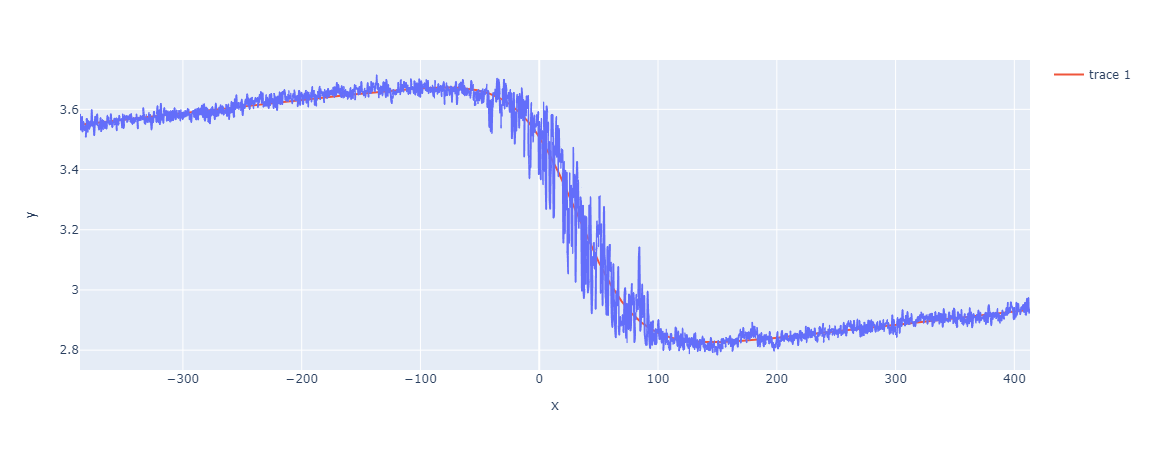

NameError: name 'info' is not defined

In [79]:
row = 21
dat = get_dat(8225)
x = dat.Data.x_array[::50]
y = dat.Data.i_sense[row][::50]
# x, y = CU.bin_data([x,y], bin_size=100)
fig1 = px.line(x=x, y=y)
fig1.add_trace(go.Scatter(mode='lines', x=x, y=dat.Transition.all_fits[row].eval_fit(x=x)))
fig1.show()

x = info.x
y = info.avg_data
x, y = CU.bin_data([x, y], bin_size=100)

fig2 = px.line(x=x, y=y)
fig2.add_trace(go.Scatter(mode='lines', x=x, y=info.avg_fit.eval_fit(x=x)))
fig2.show()

# Look at Single Dat

## Calculate Average dT/amp from dats

In [145]:
filt_name = 'LCT/0.196'
filt_val = lambda dat: dat.Logs.fds['LCT/0.196']
filt_func = lambda dat: (filt_val(dat) < -2200)

temp_dats = [dat for dat in dats if filt_func(dat)]
temp_dats = CU.order_list(temp_dats, [filt_val(dat) for dat in temp_dats])

get_vals, names, units = list(), list(), list()

get_vals.append(lambda dat: dat.Other.EA_values.dT)
names.append('dT')
units.append('mV')

get_vals.append(lambda dat: dat.Other.EA_values.amp)
names.append('Amp')
units.append('nA')

get_vals.append(lambda dat: dat.Other.EA_values.tc)
names.append('Theta')
units.append('mV')



print(f'For dats{temp_dats[0].datnum}->{temp_dats[-1].datnum} ({filt_name}={filt_val(temp_dats[0]):.0f}->{filt_val(temp_dats[-1]):.0f}mV) avg:')
for get_val, name, unit in zip(get_vals, names, units):
    dts = [get_val(dat) for dat in temp_dats]
    print(f'\t {name} = {np.nanmean(dts):.3f}{unit}, stdev = {np.nanstd(dts):.3f}{unit}')

For dats7643->7574 (LCT/0.16=-2307->-2240mV) avg:
	 dT = 2.586mV, stdev = 0.123mV
	 Amp = 0.871nA, stdev = 0.014nA
	 Theta = 23.471mV, stdev = 1.069mV


In [125]:
val = -430/0.196
print(f'Closest DAC step below {val:.2f}mV = {val - val%20000/(2**16):.2f}mV')

Closest DAC step below -2193.88mV = -2194.15mV


In [204]:
nlcts = np.arange(-2276.34, -2239.53, 3*20000/(2**16), dtype=np.float64)
olcts = np.array([-371, -365])/0.196
olps = np.array([-439, -454.4])

nlps = np.interp(nlcts, olcts, olps)
print(f'Total of {len(nlcts)} positions:\n' \
    f'New LCTs/0.196 = {[round(v, 1) for v in nlcts]}\n' \
     f'New LPs*2 = {[round(v, 1) for v in nlps]}')

Total of 41 positions:
New LCTs/0.163 = [-2276.3, -2275.4, -2274.5, -2273.6, -2272.7, -2271.8, -2270.8, -2269.9, -2269.0, -2268.1, -2267.2, -2266.3, -2265.4, -2264.4, -2263.5, -2262.6, -2261.7, -2260.8, -2259.9, -2258.9, -2258.0, -2257.1, -2256.2, -2255.3, -2254.4, -2253.5, -2252.5, -2251.6, -2250.7, -2249.8, -2248.9, -2248.0, -2247.0, -2246.1, -2245.2, -2244.3, -2243.4, -2242.5, -2241.5, -2240.6, -2239.7]
New LPs*2 = [-439.0, -439.3, -439.7, -440.0, -440.4, -440.8, -441.2, -441.6, -442.0, -442.3, -442.7, -443.1, -443.5, -443.9, -444.3, -444.6, -445.0, -445.4, -445.8, -446.2, -446.5, -446.9, -447.3, -447.7, -448.1, -448.5, -448.8, -449.2, -449.6, -450.0, -450.4, -450.8, -451.1, -451.5, -451.9, -452.3, -452.7, -453.1, -453.4, -453.8, -454.2]


In [154]:
nlcss = np.arange(-230, -200, 5*20000/(2**16), dtype=np.float64)
olcss = np.array([-224, -215.76])
olcb = np.array([-662.54, -679.93])

line = lm.models.LinearModel()
fit = line.fit(olcb, x=olcss)

print(f'Total of {len(nlcss)} positions:\n' \
    f'New LCSSs = {[round(v, 1) for v in nlcss]}\n' \
     f'New LCBs = {[round(v,1) for v in fit.eval(x=nlcss)]}')

# nlcb = np.interp(nlcss, olcss, olcb, )
# print(f'Total of {len(nlcss)} positions:\n' \
#     f'New LCSSs/0.196 = {[round(v, 1) for v in nlcss]}\n' \
#      f'New LCBs = {[round(v, 1) for v in nlcb]}')

Total of 20 positions:
New LCSSs = [-230.0, -228.5, -226.9, -225.4, -223.9, -222.4, -220.8, -219.3, -217.8, -216.3, -214.7, -213.2, -211.7, -210.2, -208.6, -207.1, -205.6, -204.1, -202.5, -201.0]
New LCBs = [-649.9, -653.1, -656.3, -659.5, -662.8, -666.0, -669.2, -672.4, -675.6, -678.9, -682.1, -685.3, -688.5, -691.7, -695.0, -698.2, -701.4, -704.6, -707.8, -711.1]


In [146]:

lps = [-552,-548.8,-544,-534,-525,-515,-506,-497,-488,-480,-471,-462,-444,-427,-399,-375,-353,-340,-324,-310,-293]
lcts = [-320,-322.5,-325,-330,-335,-340,-345,-350,-355,-360,-365,-370,-380,-390,-400,-410,-420,-430,-440,-450,-460]
# lps = [-400.723, -413.541, -428.166, -435.949, -445.363, -453.602, -463.49, -471.73]
# lcts = [-399.384, -394.807, -389.314, -384.736, -379.243, -374.665, -369.172, -364.594]

fit = lm.models.LinearModel().fit(lps, x=lcts)

fig = px.line(x=lcts, y=lps)
fig.add_trace(go.Scatter(mode='lines', x=lcts, y=fit.best_fit))

nlcts = list(range(-480, -360, 5))
print(f'New LCTs = {[round(v, 0) for v in nlcts]}\nNew LP*2s = {[round(v, 1) for v in fit.eval(x=np.array(nlcts))]}')

New LCTs = [-480, -475, -470, -465, -460, -455, -450, -445, -440, -435, -430, -425, -420, -415, -410, -405, -400, -395, -390, -385, -380, -375, -370, -365]
New LP*2s = [-248.8, -258.3, -267.9, -277.4, -287.0, -296.5, -306.0, -315.6, -325.1, -334.6, -344.2, -353.7, -363.3, -372.8, -382.3, -391.9, -401.4, -410.9, -420.5, -430.0, -439.5, -449.1, -458.6, -468.2]


In [147]:
dat = get_dat(4295)
dat.Logs.fds

{'R2T(10M)': 0,
 'TC/0.001': 0,
 'LP*2': -330.2,
 'LCB': -662.84,
 'LCT': -439.76,
 'LCSQ': -769.65,
 'LCSS': -224,
 'LP*200': 1030}

In [148]:
dat = dats[0]

pd.Timestamp(dat.Logs.time_completed).time().isoformat()

'17:13:20'

In [149]:
dats = get_dats([4295, 4296, 7822, 7822+21, 7923, 7952, 7864, 8009, 8073, 8145, 8180])  # 7929

params = {'Two Part': lambda dat: dat.Logs.part_of[1] == 2,
          'Part': lambda dat: dat.Logs.part_of[0],
          'Time elapsed': lambda dat: dat.Logs.time_elapsed,
          'Width': lambda dat: dat.Data.x_array[-1]-dat.Data.x_array[0], 
          'Repeats': lambda dat: dat.Data.y_array.shape[-1],
         'LCSS': lambda dat: dat.Logs.fds['LCSS'],
         'LCSQ': lambda dat: dat.Logs.fds['LCSQ'],
         'LP*2': lambda dat: dat.Logs.fds['LP*2'],
         'LCT': lambda dat: dat.Logs.fds.get('LCT', None),
         'LCT/0.196': lambda dat: dat.Logs.fds.get('LCT/0.196', None),
         'LCB': lambda dat: dat.Logs.fds['LCB'],
         'dS': lambda dat: CU.get_nested_attr_default(dat, 'Other.EA_values.dS', None),
          'dS uncertainty': lambda dat: CU.get_nested_attr_default(dat, 'Other.EA_uncertainties.fit_dS', None),
          'Uncertainty batch size': lambda dat: CU.get_nested_attr_default(dat, 'Other.EA_analysis_params.batch_uncertainty', None),
          'Entropy fit range': lambda dat: CU.get_nested_attr_default(dat, 'Other.EA_analysis_params.E_fit_range', None),
          'Transition amp': lambda dat: CU.get_nested_attr_default(dat, 'Other.EA_values.amp', None),
          'Amp uncertainty': lambda dat: CU.get_nested_attr_default(dat, 'Other.EA_uncertainties.amp', None),
          'Theta': lambda dat: CU.get_nested_attr_default(dat, 'Other.EA_values.tc', None),
          'Theta uncertainty': lambda dat: CU.get_nested_attr_default(dat, 'Other.EA_uncertainties.tc', None),
          'Transition fit range': lambda dat: CU.get_nested_attr_default(dat, 'Other.EA_analysis_params.CT_fit_range', None),
          'RCSS': lambda dat: dat.Logs.bds['RCSS'],
          'RCSQ': lambda dat: dat.Logs.bds['RCSQ'],
          'RCT': lambda dat: dat.Logs.bds['RCT'],
          'RCB': lambda dat: dat.Logs.bds['RCB'],
          'R2T(10M)': lambda dat: dat.Logs.fds.get('R2T(10M)', None),
          'R2T/0.001': lambda dat: dat.Logs.fds.get('R2T/0.001', None),
          'HQPC bias mV': lambda dat: dat.SquareEntropy.SquareAWG.AWs[0][0][1]
         }

df = pd.DataFrame()
for dat in dats:
    data = pd.Series({k: v(dat) for k, v in params.items()}, name=f'Dat{dat.datnum}')
    df = pd.concat((df, data), axis=1)

    
df

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


,Dat4295,Dat4296,Dat7822,Dat7843,Dat7923,Dat7952,Dat7864,Dat8009,Dat8073,Dat8145,Dat8180
Two Part,True,True,False,False,False,False,False,False,False,False,False
Part,1,2,1,1,1,1,1,1,1,1,1
Time elapsed,157.6,233.51,1038,627.14,1038,417.88,1038.3,417.87,501.82,502.2,502.24
Width,1999.96,400,2000,1200,2000,800,2000,800,800,800,800
Repeats,15,100,25,25,25,25,25,25,30,30,30
LCSS,-224,-224,-215.76,-215.76,-224,-224,-215.76,-224,-215.76,-210.57,-211.18
LCSQ,-769.65,-769.65,-783.69,-783.69,-769.35,-769.35,-783.69,-767.52,-785.83,-799.56,-797.73
LP*2,-330.2,-330.2,-411.99,-411.99,-316.47,-317.08,-408.63,-401.92,-397.34,-397.34,-397.03
LCT,-439.76,-439.76,None,None,None,None,None,None,None,None,None
LCT/0.196,None,None,-1986.7,-1986.7,-2244,-2244,-1986.4,-2037.7,-2037.7,-2037.7,-2037.7


In [150]:
import numbers
isinstance(np.float64(10), numbers.Number)

True

In [151]:
fit

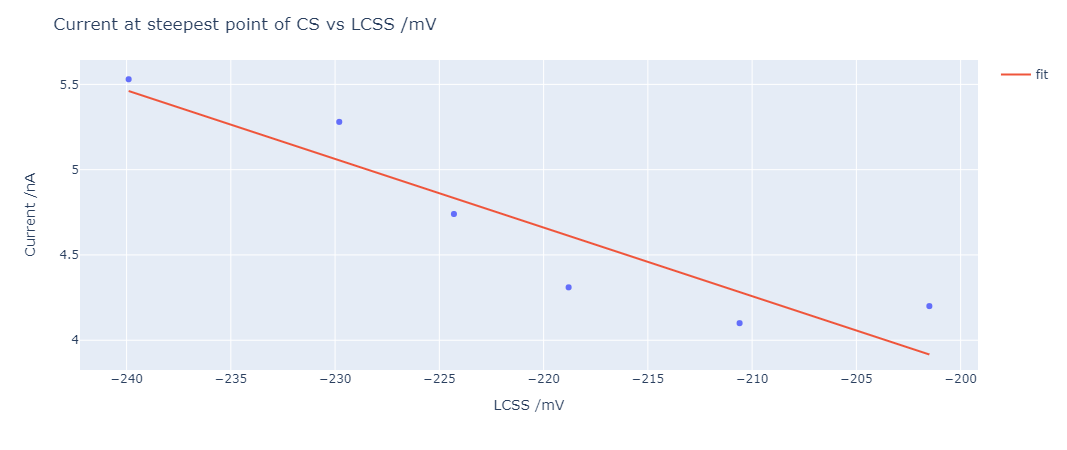

In [152]:
x = np.array([-239.9, -229.8, -224.3, -218.8, -210.6, -201.5], dtype=np.float32)
y = np.array([5.53, 5.28, 4.74, 4.31, 4.1, 4.2], dtype=np.float32)

quad = lm.models.LinearModel()
pars = lm.Parameters()

fit = quad.fit(y, x=x)

fig = px.scatter(x=x, y=y)
fx = np.linspace(x[0], x[-1], 100)

fig.add_trace(go.Scatter(mode='lines', x=fx, y=fit.eval(x=fx), name='fit'))

PlU.fig_setup(fig, title='Current at steepest point of CS vs LCSS /mV', x_label='LCSS /mV', y_label='Current /nA')

fig.show()

In [153]:
print(f'{[round(v, 2) if v < 5.8 else 5.8 for v in fit.eval(x=nlcss)]}')
print(nlcss)

[5.8, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8, 5.75, 5.69, 5.63, 5.57, 5.51, 5.44, 5.38, 5.32, 5.26, 5.2, 5.14, 5.08, 5.01, 4.95, 4.89, 4.83, 4.77, 4.71]
[-270.         -268.47412109 -266.94824219 -265.42236328 -263.89648438
 -262.37060547 -260.84472656 -259.31884766 -257.79296875 -256.26708984
 -254.74121094 -253.21533203 -251.68945312 -250.16357422 -248.63769531
 -247.11181641 -245.5859375  -244.06005859 -242.53417969 -241.00830078
 -239.48242188 -237.95654297 -236.43066406 -234.90478516 -233.37890625
 -231.85302734 -230.32714844 -228.80126953 -227.27539062 -225.74951172
 -224.22363281 -222.69775391 -221.171875  ]


In [84]:
dats = get_dats((7694, 7699+1))
for dat in dats:
    print(dat.datnum, dat.Logs.temps, dat.Logs.time_completed)

100% (6 of 6) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


7694 TEMPtuple(fiftyk=49.215, fourk=3.8886, mag=4.7251, mc=0.181021, still=0.67156) Sunday, October 18, 2020 01:29:28
7695 TEMPtuple(fiftyk=49.237, fourk=3.9131, mag=4.6943, mc=0.174486, still=0.67239) Sunday, October 18, 2020 02:00:17
7696 TEMPtuple(fiftyk=49.263, fourk=3.8929, mag=4.6822, mc=0.164793, still=0.67134) Sunday, October 18, 2020 02:31:35
7697 TEMPtuple(fiftyk=49.273, fourk=3.9025, mag=4.6924, mc=0.157036, still=0.67251) Sunday, October 18, 2020 03:03:49
7698 TEMPtuple(fiftyk=49.251, fourk=3.9079, mag=4.7094, mc=0.147644, still=0.67127) Sunday, October 18, 2020 03:37:17
7699 TEMPtuple(fiftyk=49.246, fourk=3.8957, mag=4.6772, mc=0.136789, still=0.67324) Sunday, October 18, 2020 04:12:14


In [92]:
insides = [78.31, 78.32, 78.36, 78.39, 78.41]
outsides  = [86.65, 86.75, 86.72, 86.79, 86.70]

ins = np.mean(insides)
ins_err = np.std(insides)

out = np.mean(outsides)
out_err = np.std(outsides)

avg = (ins+out)/2
avg_err = np.sqrt(ins_err**2+out_err**2)/2

print(f'PCD = {avg/0.5:.2f}{PM}{avg_err/0.5:.2f}mm')



PCD = 165.08±0.06mm
